# 第6章: 英語テキストの処理

---

英語のテキスト（nlp.txt）に対して，以下の処理を実行せよ．

In [1]:
%%bash

# download
if [ ! -f nlp.txt ]; then
    wget http://www.cl.ecei.tohoku.ac.jp/nlp100/data/nlp.txt
fi

wc -l nlp.txt
echo '----------'
head nlp.txt

      34 nlp.txt
----------
Natural language processing
From Wikipedia, the free encyclopedia

Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages. As such, NLP is related to the area of humani-computer interaction. Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.

History

The history of NLP generally starts in the 1950s, although work can be found from earlier periods. In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.

The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English. The authors claimed that within three or five years,

## 50. 文区切り
(. or ; or : or ? or !) → 空白文字 → 英大文字というパターンを文の区切りと見なし，入力された文書を1行1文の形式で出力せよ

In [2]:
import re
import os

with open('nlp.txt', 'r') as in_f:
    with open('nlp_split.txt', 'w') as out_f:
        for line in in_f.readlines():
            line = re.sub(r'([.;:?!])\W([A-Z])', r'\1 ||| \2', line.strip())
            for sent in line.split(' ||| '):
                out_f.write(sent.strip()+'\n')

In [3]:
%%bash

wc -l nlp_split.txt
echo '----------'
head nlp_split.txt

      69 nlp_split.txt
----------
Natural language processing
From Wikipedia, the free encyclopedia

Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages.
As such, NLP is related to the area of humani-computer interaction.
Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.

History

The history of NLP generally starts in the 1950s, although work can be found from earlier periods.


## 51. 単語の切り出し
空白を単語の区切りとみなし，50の出力を入力として受け取り，1行1単語の形式で出力せよ．ただし，文の終端では空行を出力せよ．

In [4]:
with open('nlp_split.txt', 'r') as in_f:
    with open('nlp_vocab.txt', 'w') as out_f:
        for line in in_f.readlines():
            if line:
                for word in line.split():
                    out_f.write(word.strip()+'\n')
                out_f.write('\n')

In [5]:
%%bash

wc -l nlp_vocab.txt
echo '----------'
head nlp_vocab.txt

    1328 nlp_vocab.txt
----------
Natural
language
processing

From
Wikipedia,
the
free
encyclopedia



## 52. ステミング
51の出力を入力として受け取り，Porterのステミングアルゴリズムを適用し，単語と語幹をタブ区切り形式で出力せよ． Pythonでは，Porterのステミングアルゴリズムの実装としてstemmingモジュールを利用するとよい．

In [6]:
from nltk.stem.porter import PorterStemmer

stermmer = PorterStemmer()
with open('nlp_vocab.txt', 'r') as in_f:
    with open('nlp_stem.txt', 'w') as out_f:
        for word in in_f.readlines():
            word = word.strip().strip('.,"()')
            if word:
                out_f.write(stermmer.stem(word)+'\n')

In [7]:
%%bash

head nlp_stem.txt

natur
languag
process
from
wikipedia
the
free
encyclopedia
natur
languag


## 53. Tokenization
Stanford Core NLPを用い，入力テキストの解析結果をXML形式で得よ．また，このXMLファイルを読み込み，入力テキストを1行1単語の形式で出力せよ．

In [8]:
%%bash

scriptdir="stanford-corenlp-full-2015-12-09"

java -mx5g -cp "$scriptdir/*" edu.stanford.nlp.pipeline.StanfordCoreNLP \
 -inputFile nlp_split.txt -outputFile nlp -ssplit.eolonly -outputFormat "xml"

[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Searching for resource: StanfordCoreNLP.properties
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Searching for resource: edu/stanford/nlp/pipeline/StanfordCoreNLP.properties
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
Reading POS tagger model from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ..

In [9]:
%%bash

head nlp.xml

<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet href="CoreNLP-to-HTML.xsl" type="text/xsl"?>
<root>
  <document>
    <sentences>
      <sentence id="1" line="1">
        <tokens>
          <token id="1">
            <word>Natural</word>
            <lemma>natural</lemma>


In [10]:
import xml.etree.ElementTree as ET
tree = ET.parse('nlp.xml')
root = tree.getroot()
sentences = root.findall('.//sentences/sentence')
len(sentences)

54

In [11]:
for sent in  sentences[2:4]:
    for token in sent.findall('tokens/token'):
        word = token.find('word').text
        print(word)
    print()

Natural
language
processing
-LRB-
NLP
-RRB-
is
a
field
of
computer
science
,
artificial
intelligence
,
and
linguistics
concerned
with
the
interactions
between
computers
and
human
-LRB-
natural
-RRB-
languages
.

As
such
,
NLP
is
related
to
the
area
of
humani-computer
interaction
.



## 54. 品詞タグ付け
Stanford Core NLPの解析結果XMLを読み込み，単語，レンマ，品詞をタブ区切り形式で出力せよ．

In [12]:
sent = sentences[3]
for token in sent.findall('tokens/token'):
    word = token.find('word').text
    lemma = token.find('lemma').text
    pos = token.find('POS').text
    print('\t'.join([word, lemma, pos]))

As	as	IN
such	such	JJ
,	,	,
NLP	nlp	NN
is	be	VBZ
related	relate	VBN
to	to	TO
the	the	DT
area	area	NN
of	of	IN
humani-computer	humani-computer	JJ
interaction	interaction	NN
.	.	.


## 55. 固有表現抽出
入力文中の人名をすべて抜き出せ．

In [13]:
for sent in sentences:
    for token in sent.findall('tokens/token'):
        ner = token.find('NER').text
        if ner == 'PERSON':
            print(token.find('word').text)

Alan
Turing
Joseph
Weizenbaum
MARGIE
Schank
Wilensky
Meehan
Lehnert
Carbonell
Lehnert
Jabberwacky
Moore


## 56. 共参照解析
Stanford Core NLPの共参照解析の結果に基づき，文中の参照表現（mention）を代表参照表現（representative mention）に置換せよ．ただし，置換するときは，「代表参照表現（参照表現）」のように，元の参照表現が分かるように配慮せよ．

In [14]:
for coref in root.findall('.//coreference/coreference'):
    representative = ''
    for token in coref.findall('mention'):
        if 'representative' in token.attrib and token.attrib['representative'] == "true":
            representative = token.find('text').text
            print(representative)
        mention = token.find('text').text
        print(representative, '(%s)' % mention)
    print()

machine translation
machine translation (machine translation)
machine translation (machine translation)

hand-written rules
hand-written rules (hand-written rules)
hand-written rules (the rules)
hand-written rules (the rules)

the corresponding systems of government
the corresponding systems of government (the corresponding systems of government)
the corresponding systems of government (systems of hard if-then rules similar to existing hand-written rules)
the corresponding systems of government (These systems)
the corresponding systems of government (these systems , which was -LRB- and often continues to be -RRB-)
the corresponding systems of government (these systems)
the corresponding systems of government (these systems)

1978
1978 (1978)
1978 (1978)

The machine-learning paradigm
The machine-learning paradigm (The machine-learning paradigm)
The machine-learning paradigm (The paradigm of machine learning)

the late 1980s
the late 1980s (the late 1980s)
the late 1980s (the late 1980s

## 57. 係り受け解析
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

In [15]:
dependency_graph = []
for sent in sentences:
    nodes = set([])
    edges = set([])
    for dep in sent.findall('dependencies[@type="collapsed-dependencies"]/dep'):
        governor = dep.find('governor')
        dependent = dep.find('dependent')
        nodes.add((governor.attrib['idx'], governor.text))
        nodes.add((dependent.attrib['idx'], dependent.text))
        edges.add((governor.attrib['idx'], dependent.attrib['idx'], dep.attrib['type']))
    dependency_graph.append((nodes, edges))

In [16]:
import pydot

def build_graph(sent):
    g = pydot.Dot(graph_type="digraph")
    nodes, edges = sent 

    # nodes
    for node in sorted(list(nodes), key=lambda x: int(x[0])):
        surface = node[1] if node[1] not in [','] else '"'+node[1]+'"'
        g.add_node(pydot.Node(node[0], label=surface))

    # edges
    for edge in edges:
        g.add_edge(pydot.Edge(edge[0], edge[1], label=edge[2].replace(':', '_')))
    
    return g.to_string()

In [17]:
from IPython.display import SVG, display
import subprocess

# source: http://www.nltk.org/_modules/nltk/parse/dependencygraph.html

def display_graph(dot_string):
    process = subprocess.Popen(
        ['dot', '-Tsvg'],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True,
    )
    out, err = process.communicate(dot_string)
    display(SVG(out))
    

As such , NLP is related to the area of humani-computer interaction .


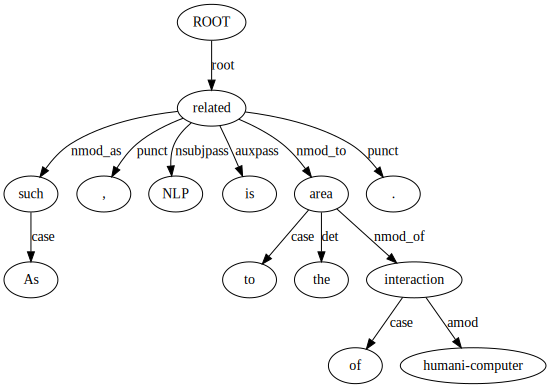

In [18]:
sent_id = 3
print(' '.join([token.find('word').text for sent in sentences[sent_id:sent_id+1] 
                for token in sent.findall('tokens/token')]))
sent = dependency_graph[sent_id]
graph = build_graph(sent)
display_graph(graph)

## 58. タプルの抽出
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）に基づき，「主語 述語 目的語」の組をタブ区切り形式で出力せよ．ただし，主語，述語，目的語の定義は以下を参考にせよ．

- 述語: nsubj関係とdobj関係の子（dependant）を持つ単語
- 主語: 述語からnsubj関係にある子（dependent）
- 目的語: 述語からdobj関係にある子（dependent）

In [19]:
from collections import defaultdict

for sent in sentences:
    pred = defaultdict(lambda: [''] * 3)
    for dep in sent.findall('dependencies[@type="collapsed-dependencies"]/dep'):
        if dep.attrib['type'] == 'nsubj':
            verb = dep.find('governor')
            subj = dep.find('dependent')
            pred[verb.attrib['idx']][0] = subj.text
            pred[verb.attrib['idx']][1] = verb.text
        elif dep.attrib['type'] == 'dobj':
            verb = dep.find('governor')
            obj = dep.find('dependent')
            pred[verb.attrib['idx']][2] = obj.text
            pred[verb.attrib['idx']][1] = verb.text
    for v in pred.values():
        if '' not in v:
            print('\t'.join(v))

understanding	enabling	computers
others	involve	generation
Turing	published	article
experiment	involved	translation
ELIZA	provided	interaction
patient	exceeded	base
ELIZA	provide	response
which	structured	information
underpinnings	discouraged	sort
that	underlies	approach
Some	produced	systems
which	make	decisions
systems	rely	which
that	contains	errors
implementations	involved	coding
algorithms	take	set
Some	produced	systems
which	make	decisions
models	have	advantage
they	express	certainty
Systems	have	advantages
Automatic	make	use
that	make	decisions


## 59. S式の解析
Stanford Core NLPの句構造解析の結果（S式）を読み込み，文中のすべての名詞句（NP）を表示せよ．入れ子になっている名詞句もすべて表示すること．

In [20]:
import regex

sent = sentences[3]
tree = sent.find('parse').text
phrases = regex.search(r'(?<rec>\((?:[^()]+ |(?&rec))*\))', tree, flags=regex.VERBOSE)
for phrase in phrases.captures('rec'):
    if phrase.startswith('(NP'):
        print(phrase)

(NP (JJ such))
(NP (NN NLP))
(NP (DT the) (NN area))
(NP (JJ humani-computer) (NN interaction))
(NP (NP (DT the) (NN area)) (PP (IN of) (NP (JJ humani-computer) (NN interaction))))


(NP (JJ such))
(NP (NN NLP))
(NP
  (NP (DT the) (NN area))
  (PP (IN of) (NP (JJ humani-computer) (NN interaction))))
(NP (DT the) (NN area))
(NP (JJ humani-computer) (NN interaction))


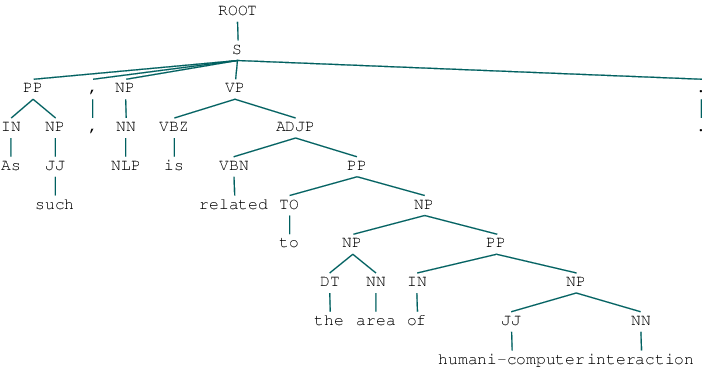

In [21]:
from nltk.tree import Tree

sent = sentences[3]
parse = sent.find('parse').text
tree = Tree.fromstring(parse)
for subtree in tree.subtrees(filter=lambda x: x.label()=='NP'):
    print(subtree)
    
tree